In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms #convert img to tensor
import torchvision.models as models  #VGG19
from torchvision.utils import save_image
from PIL import Image

import matplotlib.pyplot as plt

In [ ]:
original_vgg = models.vgg19(pretrained=True).features
print(original_vgg)
#looking for layers from paper: 0, 5, 10, 19, 28

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 104MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [2]:
#customized CNN based on VGG19
class My_VGG(nn.Module):
  def __init__(self):
    super(My_VGG, self).__init__()
    #looking for layers from paper: 0, 5, 10, 19, 28
    self.chosen_layers = [0, 5, 10, 19, 28]
    #only need the 28th layer, save some memory
    self.model = models.vgg19(pretrained=True).features[:29]

  def forward(self, x):
    layers = []

    for layer_num, layer in enumerate(self.model):
      #x = output of the layer
      x = layer(x)
      if layer_num in self.chosen_layers:
        #only want the weights from chosen layers
        layers.append(x)
    return layers

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
image_size = 540
loader = transforms.Compose(
    [
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std) unnecessary option
    ])

In [5]:
def load_img(img_name):
  img = Image.open(img_name)
  #add an extra dim for batch size
  img = loader(img).unsqueeze(0)
  return img.to(device)

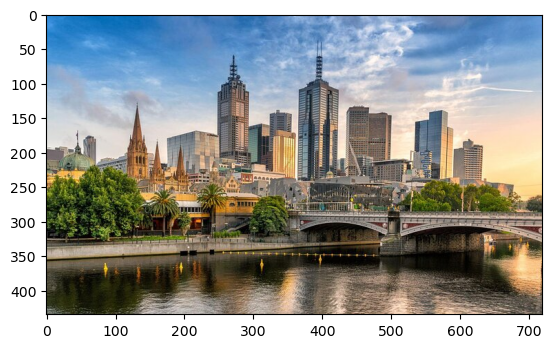

In [11]:
img = plt.imread('database/original/mel1.jpg')
plt.imshow(img)

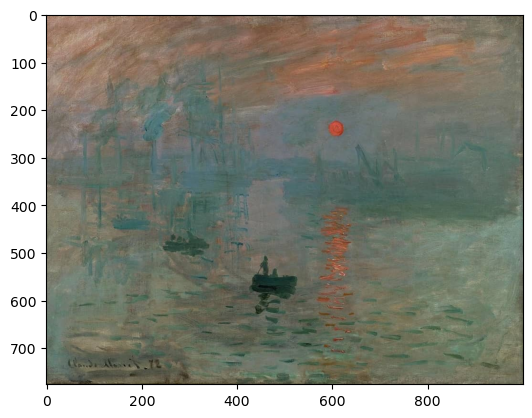

In [12]:
img = plt.imread('database/style/monet.jpg')
plt.imshow(img)

In [6]:
style_img = load_img("database/style/vg.jpg")
original_img = load_img("database/original/mel1.jpg")

In [7]:
#use my VGG
model = My_VGG().to(device).eval()
#generated_img = torch.randn(original_img.shape, device=devic, requires_grad=True) start it as a noise could be a option
#generated image is initialized as the clone of the original image for better results
generated_img = original_img.clone().requires_grad_(True)

#Hyperparameters
epochs = 2500
#0.001 or 0.005
learning_rate = 0.001
#content features
alpha = 1
#style features
beta = 0.01
#optimize the generated
optimizer = optim.Adam([generated_img], lr=learning_rate)

c:\Users\kakat\anaconda3\envs\dev\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kakat\anaconda3\envs\dev\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
for epoch in range(epochs):
  #forward pass x3
  generated_features = model(generated_img)
  original_features = model(original_img)
  style_features = model(style_img)

  style_loss = 0
  content_loss = 0

  for generated, original, style in zip(generated_features, original_features, style_features):
    batch_size, channel, height, width = generated.shape
    #content loss formula
    content_loss += torch.mean((generated - original) ** 2)

    #gram matrix of generated
    gen_gram = generated.view(channel, height * width).mm(generated.view(channel, height * width).T)
    #gram matrix of style
    style_gram = style.view(channel, height * width).mm(style.view(channel, height * width).T)

    style_loss += torch.mean((gen_gram - style_gram) ** 2)

  #total loss formula
  total_loss = alpha * content_loss + beta * style_loss

  #clear the gradient
  optimizer.zero_grad()
  #backpropagation
  total_loss.backward()
  #take a step
  optimizer.step()

  #save every 500 epochs
  if epoch % 500 == 0:
    print(total_loss)
    save_image(generated_img, "generated.png")

c:\Users\kakat\anaconda3\envs\dev\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(8342846., device='cuda:0', grad_fn=<AddBackward0>)
tensor(401379.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(59704.6328, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23830.2070, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12762.8174, device='cuda:0', grad_fn=<AddBackward0>)
